# Goal:
Create a web app that analyzes and synthesizes 2 users' spotify recent taste profiles so that we can create a playlist filled with brand new song recommendations for both of them to discover together. The playlist we curate will automatically end up in both of their spotify libraries. Would be a cool new way for people to socialize because the playlist is unique to them and can create a special experience for both to find new music together that matches their music tastes.

### Some useful links to get started: 

spotipy documentation: https://spotipy.readthedocs.io/en/2.13.0/ 

github of guy who made this code (give proper credit later): https://github.com/makispl/Spotify-Data-Analysis

he also has a useful medium article that gives steps on how to use spotify api and this code: https://towardsdatascience.com/can-a-data-scientist-replace-a-dj-spotify-manipulation-with-python-fbbd4a45ffd5

I've also created an app on spotify developers already and this is the client id: 0b2103231ba64a70885c27fbb38cfa97
and this is the client secret: 45d7d10e11474298abcb52df745e2b25

### plan
get top 50 from each user -> k=5 cluster 100 songs -> put 5 seed_songs/artists/genres into recommendations() function parameters -> keep calling function until 30 new songs that are not in either user's listen history

In [143]:
# Import the libraries
import os
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format ='retina'
import spotipy
import spotipy.util as util
from spotipy.oauth2 import SpotifyClientCredentials
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
import random
from pandas.io.json import json_normalize

## Authorization Flow

In [198]:
# Declare the credentials
cid = '0b2103231ba64a70885c27fbb38cfa97'
secret = '45d7d10e11474298abcb52df745e2b25'
redirect_uri='http://localhost:7777/callback'
username = 'areddy12434'
username2 = 'areddy12434'

# Authorization flow
scope = 'user-top-read'
token = util.prompt_for_user_token(username, scope, client_id=cid, client_secret=secret, redirect_uri=redirect_uri)

if token:
    sp = spotipy.Spotify(auth=token)
else:
    print("Can't get token for", username)
    
token2 = util.prompt_for_user_token(username2, scope, client_id=cid, client_secret=secret, redirect_uri=redirect_uri)

if token2:
    sp2 = spotipy.Spotify(auth=token2)
else:
    print("Can't get token for", username2)

## Extract User's Top Medium Term Songs

In [125]:
user1_songs = pd.read_csv('User1_top_50_songs.csv')
user2_songs = pd.read_csv('User2_top_50_songs.csv')
temp = [user1_songs, user2_songs]
temp = pd.concat(temp)
temp.reset_index(drop=True,inplace=True)
print(temp)

    Unnamed: 0                                  artist  \
0            0                            Lil Uzi Vert   
1            1                            Lil Uzi Vert   
2            2                                JACKBOYS   
3            3                                Kid Cudi   
4            4                            Lil Uzi Vert   
..         ...                                     ...   
95          45                              Felix Snow   
96          46                                    Styx   
97          47                                    Russ   
98          48  Donnie Trumpet & The Social Experiment   
99          49                                 Whethan   

                               artist_uri  \
0   spotify:artist:4O15NlyKLIASxsJ0PrXPfz   
1   spotify:artist:4O15NlyKLIASxsJ0PrXPfz   
2   spotify:artist:7A8S43ryYdbWpJKeHRZRcq   
3   spotify:artist:0fA0VVWsXO9YnASrzqfmYu   
4   spotify:artist:4O15NlyKLIASxsJ0PrXPfz   
..                               

#### Extract Users' Top 50 Tracks' Audio Features

In [126]:
user1_list = []
for song in user1_songs['song_uri']:
    row = pd.DataFrame(sp.audio_features(tracks=[song]))
    user1_list.append(row)
user1_df = pd.concat(user1_list)

user2_list = []
for song in user2_songs['song_uri']:
    row = pd.DataFrame(sp.audio_features(tracks=[song]))
    user2_list.append(row)
user2_df = pd.concat(user2_list)

dfs = [user1_df, user2_df]
dfs = pd.concat(dfs)
dfs

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
0,0.817,0.656,10,-7.086,0,0.2770,0.0510,0.000000,0.1150,0.314,139.915,audio_features,0AhJag7VI8uFf3mJFsTwvf,spotify:track:0AhJag7VI8uFf3mJFsTwvf,https://api.spotify.com/v1/tracks/0AhJag7VI8uF...,https://api.spotify.com/v1/audio-analysis/0AhJ...,120076,4
0,0.771,0.654,8,-6.976,0,0.2980,0.0550,0.000000,0.2140,0.573,155.047,audio_features,56uXDJRCuoS7abX3SkzHKQ,spotify:track:56uXDJRCuoS7abX3SkzHKQ,https://api.spotify.com/v1/tracks/56uXDJRCuoS7...,https://api.spotify.com/v1/audio-analysis/56uX...,224955,4
0,0.594,0.676,2,-5.808,1,0.3440,0.1350,0.000000,0.1630,0.472,143.477,audio_features,40mjsnRjCpycdUw3xhS20g,spotify:track:40mjsnRjCpycdUw3xhS20g,https://api.spotify.com/v1/tracks/40mjsnRjCpyc...,https://api.spotify.com/v1/audio-analysis/40mj...,181145,4
0,0.806,0.809,1,-7.180,1,0.1590,0.1410,0.000086,0.0739,0.685,95.043,audio_features,3hR48Bj9Wgl6xunDG4nsRZ,spotify:track:3hR48Bj9Wgl6xunDG4nsRZ,https://api.spotify.com/v1/tracks/3hR48Bj9Wgl6...,https://api.spotify.com/v1/audio-analysis/3hR4...,189545,4
0,0.862,0.650,10,-6.978,0,0.3550,0.0207,0.000000,0.5680,0.658,131.194,audio_features,4lAQfuREAHG8IC0PiiigBt,spotify:track:4lAQfuREAHG8IC0PiiigBt,https://api.spotify.com/v1/tracks/4lAQfuREAHG8...,https://api.spotify.com/v1/audio-analysis/4lAQ...,115350,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,0.758,0.416,11,-7.897,0,0.0842,0.2950,0.000000,0.0958,0.457,100.018,audio_features,0Cm3Xy7wF0HogyeVRJ1DZs,spotify:track:0Cm3Xy7wF0HogyeVRJ1DZs,https://api.spotify.com/v1/tracks/0Cm3Xy7wF0Ho...,https://api.spotify.com/v1/audio-analysis/0Cm3...,157200,4
0,0.324,0.335,0,-15.595,1,0.0355,0.0990,0.000001,0.0995,0.141,119.513,audio_features,0PsbWiVtix5FoTZ1s00mEl,spotify:track:0PsbWiVtix5FoTZ1s00mEl,https://api.spotify.com/v1/tracks/0PsbWiVtix5F...,https://api.spotify.com/v1/audio-analysis/0Psb...,367000,4
0,0.743,0.507,2,-3.164,0,0.1350,0.6060,0.000000,0.1110,0.358,79.011,audio_features,5dM52n0cmm1Kt8abAP1l9Z,spotify:track:5dM52n0cmm1Kt8abAP1l9Z,https://api.spotify.com/v1/tracks/5dM52n0cmm1K...,https://api.spotify.com/v1/audio-analysis/5dM5...,161071,4
0,0.511,0.596,0,-6.560,1,0.2240,0.5300,0.000000,0.0798,0.554,158.063,audio_features,6fTdcGsjxlAD9PSkoPaLMX,spotify:track:6fTdcGsjxlAD9PSkoPaLMX,https://api.spotify.com/v1/tracks/6fTdcGsjxlAD...,https://api.spotify.com/v1/audio-analysis/6fTd...,226014,4


In [127]:
#normalize tempo feature
dfs.drop(['type','track_href','analysis_url','time_signature','duration_ms','uri','instrumentalness','liveness','loudness','key','mode'],1,inplace=True)
dfs.set_index('id',inplace=True)
dfs.head(1)

,danceability,energy,speechiness,acousticness,valence,tempo
id,,,,,,
0AhJag7VI8uFf3mJFsTwvf,0.817,0.656,0.277,0.051,0.314,139.915


In [128]:
dfs.describe()

,danceability,energy,speechiness,acousticness,valence,tempo
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,0.691770,0.660068,0.205413,0.182442,0.495662,120.351220
std,0.153376,0.165149,0.158345,0.202386,0.223225,27.426881
min,0.147000,0.008780,0.027800,0.000008,0.026000,70.776000
25%,0.570750,0.551500,0.063475,0.027325,0.343750,99.501750
50%,0.729000,0.679000,0.179000,0.106000,0.472500,118.413000
75%,0.818000,0.796000,0.300250,0.266250,0.659000,139.855000
max,0.929000,0.933000,0.902000,0.899000,0.974000,177.728000


## K-Means Clustering

In [129]:
#get 20 clusters of x songs -> perform the recommendation function 20 times 
clusters = 20
kmeans = KMeans(n_clusters=clusters)
kmeans.fit(dfs)
len(kmeans.labels_)

100

### Visualize Clustering

In [130]:
from sklearn.decomposition import PCA 

pca = PCA(3) 
pca.fit(dfs) 
  
pca_data = pd.DataFrame(pca.transform(dfs)) 
  
print(pca_data.head())

           0         1         2
0  19.563788  0.096843 -0.162199
1  34.695886 -0.106762 -0.056146
2  23.126009  0.016059 -0.029756
3 -25.308185 -0.260227 -0.023374
4  10.842986 -0.226678 -0.041056


In [131]:
from matplotlib import colors as mcolors 
import math 
   
''' Generating different colors in ascending order  
                                of their hsv values '''
colors = list(zip(*sorted(( 
                    tuple(mcolors.rgb_to_hsv( 
                          mcolors.to_rgba(color)[:3])), name) 
                     for name, color in dict( 
                            mcolors.BASE_COLORS, **mcolors.CSS4_COLORS 
                                                      ).items())))[1] 
   
   
# number of steps to taken generate n(clusters) colors  
skips = math.floor(len(colors[5 : -5])/clusters) 
cluster_colors = colors[5 : -5 : skips] 

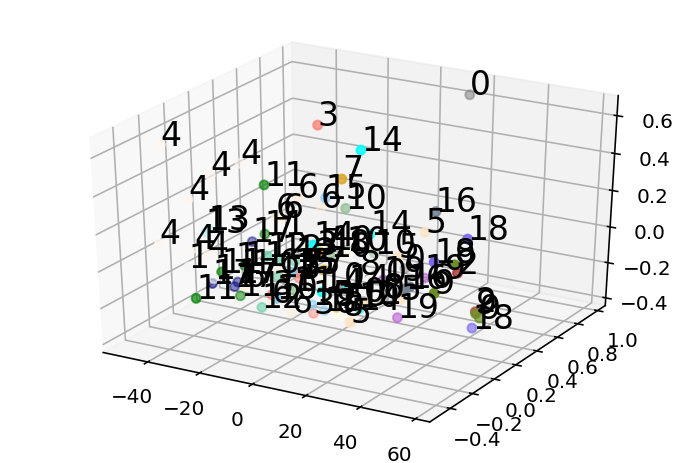

In [132]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt 
from matplotlib.animation import FuncAnimation
   
fig = plt.figure() 
ax = fig.add_subplot(111, projection = '3d') 
ax.scatter(pca_data[0], pca_data[1], pca_data[2],  
           c = list(map(lambda label : cluster_colors[label], 
                                            kmeans.labels_))) 
   
str_labels = list(map(lambda label:'% s' % label, kmeans.labels_)) 
   
list(map(lambda data1, data2, data3, str_label: 
        ax.text(data1, data2, data3, s = str_label, size = 16.5, 
        zorder = 20, color = 'k'), pca_data[0], pca_data[1], 
        pca_data[2], str_labels)) 

plt.show()

### Cluster Analysis

In [133]:
scaler = MinMaxScaler()
scaled = scaler.fit_transform(dfs)
y_kmeans = kmeans.fit_predict(scaled)
y_kmeans

array([19, 12,  5,  0,  1,  9, 11,  1,  8, 14, 15, 19,  0, 13, 11,  5, 18,
       10,  3,  7,  5,  1,  7, 19,  7,  2, 13,  3, 15, 17,  5,  5, 16,  3,
       15, 11,  7, 11,  5, 18, 17,  8,  4,  7,  6, 12,  1,  2, 16, 17, 18,
        0,  0, 13,  2, 14,  7,  6,  0, 17,  0, 18, 14, 12, 10,  1,  7, 15,
        3,  4,  6, 18,  0,  3,  3,  4,  7, 19, 18,  1, 12,  7, 10, 10,  7,
        7, 11,  5,  7, 10, 12,  7,  2,  8,  1,  6,  6, 14, 13, 14])

In [134]:
dfs['cluster'] = y_kmeans
dfs['artist'] = temp.artist.tolist()
dfs['title'] = temp.song.tolist()
dfs.head()

,danceability,energy,speechiness,acousticness,valence,tempo,cluster,artist,title
id,,,,,,,,,
0AhJag7VI8uFf3mJFsTwvf,0.817,0.656,0.277,0.0510,0.314,139.915,19,Lil Uzi Vert,I Can Show You
56uXDJRCuoS7abX3SkzHKQ,0.771,0.654,0.298,0.0550,0.573,155.047,12,Lil Uzi Vert,Myron
40mjsnRjCpycdUw3xhS20g,0.594,0.676,0.344,0.1350,0.472,143.477,5,JACKBOYS,GATTI
3hR48Bj9Wgl6xunDG4nsRZ,0.806,0.809,0.159,0.1410,0.685,95.043,0,Kid Cudi,Leader Of The Delinquents
4lAQfuREAHG8IC0PiiigBt,0.862,0.650,0.355,0.0207,0.658,131.194,1,Lil Uzi Vert,Strawberry Peels (feat. Young Thug & Gunna)


In [135]:
#visualize the feature 
dfs.loc[dfs['cluster'] == 15]

,danceability,energy,speechiness,acousticness,valence,tempo,cluster,artist,title
id,,,,,,,,,
0jBTxdEGB0YvKvZhf3AEIU,0.842,0.556,0.442,0.159000,0.306,118.836,15,Lil Uzi Vert,You Better Move
5jUvv1aTcNTgTOsAGlJojn,0.929,0.563,0.490,0.000592,0.353,129.957,15,Lil Uzi Vert,Homecoming
3RMVEnANWM9KAWrYshJgNO,0.923,0.415,0.439,0.108000,0.633,125.924,15,Q Da Fool,Win (feat. Kenny Beats)
1YR9iNGXtsbrd8deR9ULDD,0.857,0.446,0.902,0.215000,0.327,100.122,15,Zack Fox,Jesus Is The One (I Got Depression)


In [136]:
#6 k-means assumed to cluster genres, but we are using k=20
dfs.groupby(['cluster']).count()

,danceability,energy,speechiness,acousticness,valence,tempo,artist,title
cluster,,,,,,,,
0,7,7,7,7,7,7,7,7
1,7,7,7,7,7,7,7,7
2,4,4,4,4,4,4,4,4
3,6,6,6,6,6,6,6,6
4,3,3,3,3,3,3,3,3
5,7,7,7,7,7,7,7,7
6,5,5,5,5,5,5,5,5
7,13,13,13,13,13,13,13,13
8,3,3,3,3,3,3,3,3


In [137]:
#create list of lists of song ids to put into recommendation function
i=0
list_of_recs = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
while i<20:
    list_of_recs[i] = dfs.loc[dfs['cluster'] == i].index.to_list()
    i+=1
len(list_of_recs)
print(list_of_recs)

[['3hR48Bj9Wgl6xunDG4nsRZ', '0nbXyq5TXYPCO7pr3N8S4I', '7fPuWrlpwDcHm5aHCH5D9t', '0y60itmpH0aPKsFiGxmtnh', '4nK5YrxbMGZstTLbvj6Gxw', '7lQ8MOhq6IN2w8EYcFNSUk', '0nbXyq5TXYPCO7pr3N8S4I'], ['4lAQfuREAHG8IC0PiiigBt', '6gWzuZHMKNtjLUsTPHCX10', '2bQxqezLVNiJVeLO0RWPON', '1Gz96Ab9xAEcaUTwaFx0ON', '1raaNykBg1bDnWENUiglUA', '78QR3Wp35dqAhFEc2qAGjE', '4jIb022gI284OzhbG16Q5L'], ['57hCSu4zMTdnSum7NBL1Ye', '0VjIjW4GlUZAMYd2vXMi3b', '3HBj2yLbgrJv1VWbMpU5sc', '0XzyXP0E9jsoOwu5Rd7hTV'], ['6NV7ai8z9hu4PAGWP6xfmw', '70IshybNQ8EyKa34kndjgo', '1u8Fi9Nnb7PQVZlOmSvKgY', '1H7zdcRD0gLGQY0w5ejGgX', '6K4t31amVTZDgR3sKmwUJJ', '3lB0GMiI5KxDbTOG8V3bOx'], ['70QT8Tr8gnAEkeLW3WwN3C', '6Nle9hKrkL1wQpwNfEkxjh', '5RqR4ZCCKJDcBLIn4sih9l'], ['40mjsnRjCpycdUw3xhS20g', '1BXRj9TBkcxhBWm0kJZ9v3', '7In1dVQMQ9T7NFVD0czfGY', '7iG6aXHLFg9tBzP6OIyuJa', '79s5XnCN4TJKTVMSmOx8Ep', '4v91QNfyj3uaYy5XyAT35a', '1o0kWPueYo94LIjPYOE5Nf'], ['3aUFrxO1B8EW63QchEl3wX', '3iIrtgucy1S2IMtozeYARI', '7jZHUhAmW5oq1cq6s8IxmK', '0Cm3Xy7wF0HogyeVRJ1DZs'

In [138]:
j = 0
adj_list_of_recs = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
while j<20:
    if len(list_of_recs[j]) < 6:
        adj_list_of_recs[j] = list_of_recs[j]
    else:
        adj_list_of_recs[j] = random.sample(list_of_recs[j], 5)
    j += 1

print(adj_list_of_recs)


[['7lQ8MOhq6IN2w8EYcFNSUk', '4nK5YrxbMGZstTLbvj6Gxw', '0nbXyq5TXYPCO7pr3N8S4I', '0nbXyq5TXYPCO7pr3N8S4I', '7fPuWrlpwDcHm5aHCH5D9t'], ['4jIb022gI284OzhbG16Q5L', '2bQxqezLVNiJVeLO0RWPON', '1Gz96Ab9xAEcaUTwaFx0ON', '1raaNykBg1bDnWENUiglUA', '78QR3Wp35dqAhFEc2qAGjE'], ['57hCSu4zMTdnSum7NBL1Ye', '0VjIjW4GlUZAMYd2vXMi3b', '3HBj2yLbgrJv1VWbMpU5sc', '0XzyXP0E9jsoOwu5Rd7hTV'], ['6NV7ai8z9hu4PAGWP6xfmw', '6K4t31amVTZDgR3sKmwUJJ', '70IshybNQ8EyKa34kndjgo', '1u8Fi9Nnb7PQVZlOmSvKgY', '3lB0GMiI5KxDbTOG8V3bOx'], ['70QT8Tr8gnAEkeLW3WwN3C', '6Nle9hKrkL1wQpwNfEkxjh', '5RqR4ZCCKJDcBLIn4sih9l'], ['7In1dVQMQ9T7NFVD0czfGY', '1o0kWPueYo94LIjPYOE5Nf', '79s5XnCN4TJKTVMSmOx8Ep', '7iG6aXHLFg9tBzP6OIyuJa', '40mjsnRjCpycdUw3xhS20g'], ['3aUFrxO1B8EW63QchEl3wX', '3iIrtgucy1S2IMtozeYARI', '7jZHUhAmW5oq1cq6s8IxmK', '0Cm3Xy7wF0HogyeVRJ1DZs', '0PsbWiVtix5FoTZ1s00mEl'], ['1LeItUMezKA1HdCHxYICed', '7im3jaJBEYivH5JKXMh1Yy', '3R1k8P1MrDdLSRhlTaaWAS', '62N2JSA0jHmSH7Va9t7hIf', '4lLmG1fatRUgnRz0Ol0WUi'], ['6NtoGjIBp9gtGpDB38o

-------------------------------------------------------------------------------------------

In [170]:
#Time to Get Recommendation
k = 0
list_of_recommendations = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
while k < 20:
    if len(adj_list_of_recs[k]) < 4:
        list_of_recommendations[k] = sp.recommendations(seed_tracks=adj_list_of_recs[k],limit=1)
    else:
        list_of_recommendations[k] = sp.recommendations(seed_tracks=adj_list_of_recs[k],limit=2)
    k += 1

list_of_recommendations[3]

{'tracks': [{'album': {'album_type': 'ALBUM',
    'artists': [{'external_urls': {'spotify': 'https://open.spotify.com/artist/14rl122F3uMCloqdEVV9WL'},
      'href': 'https://api.spotify.com/v1/artists/14rl122F3uMCloqdEVV9WL',
      'id': '14rl122F3uMCloqdEVV9WL',
      'name': 'Elaquent',
      'type': 'artist',
      'uri': 'spotify:artist:14rl122F3uMCloqdEVV9WL'}],
    'available_markets': ['AD',
     'AE',
     'AR',
     'AT',
     'AU',
     'BE',
     'BG',
     'BH',
     'BO',
     'BR',
     'CA',
     'CH',
     'CL',
     'CO',
     'CR',
     'CY',
     'CZ',
     'DE',
     'DK',
     'DO',
     'DZ',
     'EC',
     'EE',
     'EG',
     'ES',
     'FI',
     'FR',
     'GB',
     'GR',
     'GT',
     'HK',
     'HN',
     'HU',
     'ID',
     'IE',
     'IL',
     'IN',
     'IS',
     'IT',
     'JO',
     'JP',
     'KW',
     'LB',
     'LI',
     'LT',
     'LU',
     'LV',
     'MA',
     'MC',
     'MT',
     'MX',
     'MY',
     'NI',
     'NL',
     'NO',
    

In [188]:
pd.json_normalize(list_of_recommendations[15], record_path='tracks').id

type(pd.json_normalize(list_of_recommendations[15], record_path='tracks').id)


pandas.core.frame.DataFrame

In [217]:
list_of_recommendations_converted = []
l = 0

while l < 20:
    list_of_recommendations_converted.append(pd.json_normalize(list_of_recommendations[l], record_path='tracks').id.tolist())
    l += 1

flatlist_of_recommendations_converted = [item for elem in list_of_recommendations_converted for item in elem]

print(flatlist_of_recommendations_converted)

len(flatlist_of_recommendations_converted)

['6LcauUZjF1eXQrgqMUecHX', '26rdOwwjC2UnweK3xeS58u', '5lFaXYvG3BhwOaEsxglDO0', '1z1ztKUrDr09ZSMDnN3QIG', '5J5PXmMdQ2nh1lZOal8KmK', '1POGnQmq4GcPCTzQB26JMn', '6jtDUARlNm9PNUqrL7cMOg', '7qwt4xUIqQWCu1DJf96g2k', '1KyZ4rUiW2lkqGNLQYKpcC', '3ekxXNSH4mgUnMprSnopls', '77lHSh6eoMiKWRxczAPQ1k', '36vTL8WP4ZoD1bbUaW0V3E', '6tZ3b7ik1QDXFAZlXib0YZ', '2D20D6gxMn8iJV4ij30DIV', '2zsWRxMcUdGjj8TnWkVKw0', '4ea9w8c4ROqiZpJVhfBA3m', '3fZbxndrIeoARRSy3T6Jfa', '1XRgIKC5TPwo7nWGyKqgG0', '6mbC4spYkphdL4Q9lpEJLt', '6NvSxE4pfP7TcD1OhGgaZW', '3axd6nS2OpTthBIv7Fv8LB', '51rXHuKN8Loc4sUlKPODgH', '3sdYpdTTn4fdfu4cyisnt0', '5IdQEHgtmj9th3OkfQKhf8', '0ECs7wpW9157Tk5yBUGbE0', '1ThmUihH9dF8EV08ku5AXN', '1XXqmnOgL9k9lcRT3hncTf', '4A21gWIRgx5Uid1ZHX0OhJ', '14X1WxiHXdVRJ99cMCBzOE', '0hFII5O2DR4rnN0QHQRNBz', '46xoZsP2RqMWRbJbPlnfex', '2ZLXySbOZbdg1uLpC48zzJ', '3wwo0bJvDSorOpNfzEkfXx', '5wIjM4q7oIgiLqn8Qfoyxh', '02RCbjb9czvQKNGBmEmWob', '6tByydPskASjm9jTPkNQq0']


36

## Create the New Playlist
Next, we are going to create a new playlist and add to it all the tracks we ended up selecting:

In [195]:
# Authorization flow

scope = "playlist-modify-public"
token = util.prompt_for_user_token(username, scope, client_id=cid, client_secret=secret, redirect_uri=redirect_uri)

if token:
    sp = spotipy.Spotify(auth=token)
else:
    print("Can't get token for", username)

In [196]:
def create_playlist(sp, username, playlist_name, playlist_description):
    playlists = sp.user_playlist_create(username, playlist_name, description = playlist_description)

In [199]:
create_playlist(sp, username, 'Spotify Discover Together', 'A joint playlist created from both of your favorite songs!')

In [201]:
##Def Fetch Playlist Function

def fetch_playlists(sp, username):
    """
    Returns the user's playlists.
    """
        
    id = []
    name = []
    num_tracks = []
    
    # Make the API request
    playlists = sp.user_playlists(username)
    for playlist in playlists['items']:
        id.append(playlist['id'])
        name.append(playlist['name'])
        num_tracks.append(playlist['tracks']['total'])

    # Create the final df   
    df_playlists = pd.DataFrame({"id":id, "name": name, "#tracks": num_tracks})
    return df_playlists

In [202]:
# Find the new playlist's id
fetch_playlists(sp,username)

,id,name,#tracks
0,7HCyrxv9JX8MsoFoTp6y25,Spotify Discover Together,0
1,4Wb7aqH3HbpZ4mcRXwMU4h,Spin Workout #7,14
2,7LA9IJ8sNigtqsaNBvwQ3l,Spin Playlist #6,15
3,65slnqeZoVRPPCpirC0HlM,Spin Playlist #5,16
4,0lFPNYEPAHZSdwtOjnDw6l,Spin Playlist #4,16
5,5TWJrAhFPDB7XZU2pqyXnk,spin workout #3,17
6,7apsyLDbkWazlkEIFUemNg,Spin Workout #2,16
7,0GGGW2av6rFS4brre8BLie,spin workout #1,16
8,7mKzB9MPpUxhGFV00GklxO,Clouds,147
9,0johS0UNkAJbaOki6eIDjO,Summer Vibes,95


In [210]:
extracted_id = fetch_playlists(sp,username).id[0]

'7HCyrxv9JX8MsoFoTp6y25'

In [218]:
sp.user_playlist_add_tracks(username, extracted_id, flatlist_of_recommendations_converted, position=None)

{'snapshot_id': 'Myw5YmFkNjNhNzdjNWU0ZTQzNjhhZWVkMzhkYTAzNGQ4YjY2ZDI5NTJi'}